In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMPORTS

In [95]:
import cv2 as cv
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.auto import tqdm

from PIL import Image
from torchvision.utils import save_image

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
NUM_EPOCHS=50
LR=1e-4
BETAS=(0.5,0.999)
LAMBDA=100
IMG_HEIGHT=256
IMG_WIDTH=256

In [3]:
os.makedirs("Training")
os.makedirs("Validation")
os.makedirs("Training/female")
os.makedirs("Training/male")
os.makedirs("Validation/male")
os.makedirs("Validation/female")

In [8]:
def create_Edged_dataset():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            img = cv.imread(os.path.join(dirname, filename))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            edges=cv.Canny(img,100,200)
            edges = cv.cvtColor(edges, cv.COLOR_BGR2RGB)
            img = cv.hconcat([img, edges])
            cv.imwrite(os.path.join('/kaggle/working',dirname[44:],str(filename)),img)


In [ ]:
create_Edged_dataset()

# Dataset Class

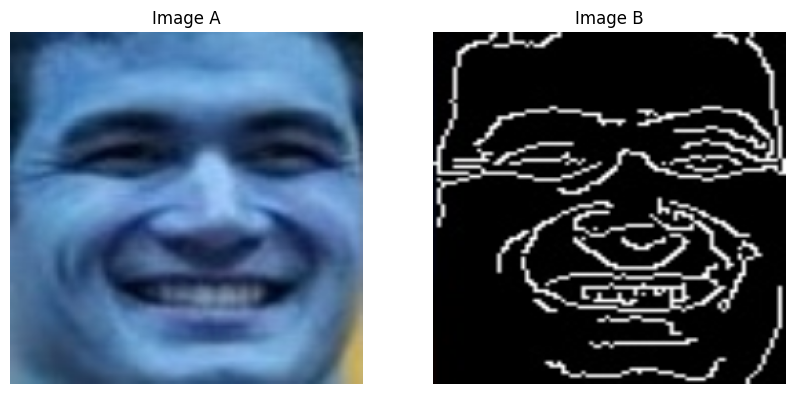

In [174]:
class ImageEdgeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.files = []
        for category in ['male', 'female']:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                self.files.append(img_path)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size

        img_A = img.crop((0, 0, w / 2, h))  # Left half
        img_B = img.crop((w / 2, 0, w, h))  # Right half

        if np.random.random() < 0.5:
            img_A = img_A.transpose(Image.FLIP_LEFT_RIGHT)
            img_B = img_B.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

## Dataset Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

In [ ]:
dataset = ImageEdgeDataset(root_dir='Training', transform=transform)

In [ ]:
sample = dataset[0]
img_A = sample['A']
img_B = sample['B']

In [ ]:
img_A_np = img_A.permute(1, 2, 0).numpy()
img_B_np = img_B.permute(1, 2, 0).numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_A_np)
axes[0].set_title('Image A')
axes[0].axis('off')

axes[1].imshow(img_B_np)
axes[1].set_title('Image B')
axes[1].axis('off')

plt.show()


In [175]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [172]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# U-Net Generator

In [70]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False):
        super().__init__()
        self.drop=drop
        self.dropout=nn.Dropout(0.5)
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [75]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,hidden_dim=64):
        super().__init__()
        self.init_down=nn.Sequential(
            nn.Conv2d(in_channels,hidden_dim,4,2,1),
            nn.LeakyReLU(0.2),
        )
        self.down1=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down3=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False) 
        
        self.bottleneck=nn.Sequential(
            nn.Conv2d(hidden_dim*8,hidden_dim*8,4,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up4=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up5=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)        
        self.up6=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)        
        self.up7=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2,in_channels,4,2,1),
            nn.Tanh()
        )
        
    def forward(self,x):
        d1 = self.init_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        bottleneck = self.bottleneck(d7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        
        return self.final_up(torch.cat([up7, d1],1))

## Testing Generator

In [227]:
def test_gen():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, hidden_dim=64)
    preds = model(x)
    print(preds.shape)
test_gen()

torch.Size([1, 3, 256, 256])


# Patch Discriminator

In [ ]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

In [224]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNN_Block(in_channels, feature, stride=1 if feature==features[-1] else 2)
                
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        x = self.initial(x)
        return self.model(x)
    

## Testing Discriminator

In [225]:
def test_disc():
    x = torch.randn((1,3,256,256))
    y = torch.randn((1,3,256,256))
    Model = Discriminator()
    pred = Model(x,y)
    print(pred.shape)

In [226]:
test_disc()

torch.Size([1, 1, 26, 26])


In [232]:
gen=Generator().cuda()
disc=Discriminator().cuda()

# Inatializations

In [233]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [234]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [235]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)

In [236]:
BCE_Loss=nn.BCEWithLogitsLoss()
L1_Loss=nn.L1Loss()

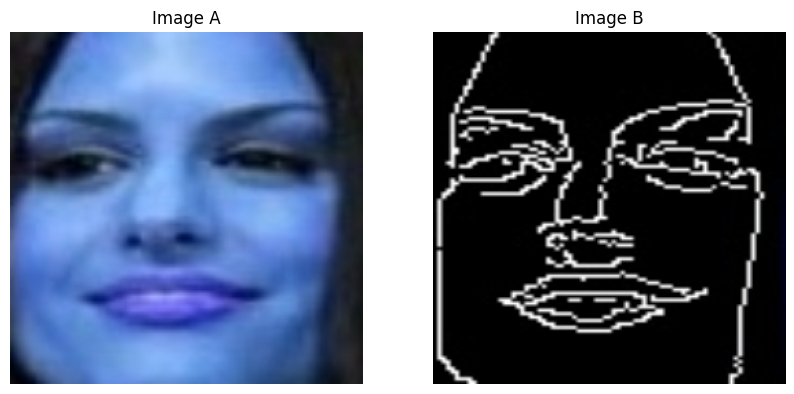

In [178]:
for idx, batch in enumerate(dataloader):
    img_A_batch = batch['A']
    img_B_batch = batch['B']
    
    # Convert batch tensors to NumPy arrays for visualization
    img_A_batch_np = img_A_batch.permute(0, 2, 3, 1).numpy()
    img_B_batch_np = img_B_batch.permute(0, 2, 3, 1).numpy()
    
    # Visualize the first image in the batch
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_A_batch_np[0])
    axes[0].set_title('Image A')
    axes[0].axis('off')
    
    axes[1].imshow(img_B_batch_np[0])
    axes[1].set_title('Image B')
    axes[1].axis('off')
    
    plt.show()
    
    # Break after the first batch for demonstration
    break

In [ ]:
def generate_images(model, test_input, tar):
    prediction = gen(test_input)
    
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0].cpu().permute(1, 2, 0), tar[0].cpu().permute(1, 2, 0), prediction[0].permute(1, 2, 0).cpu().detach().numpy()]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

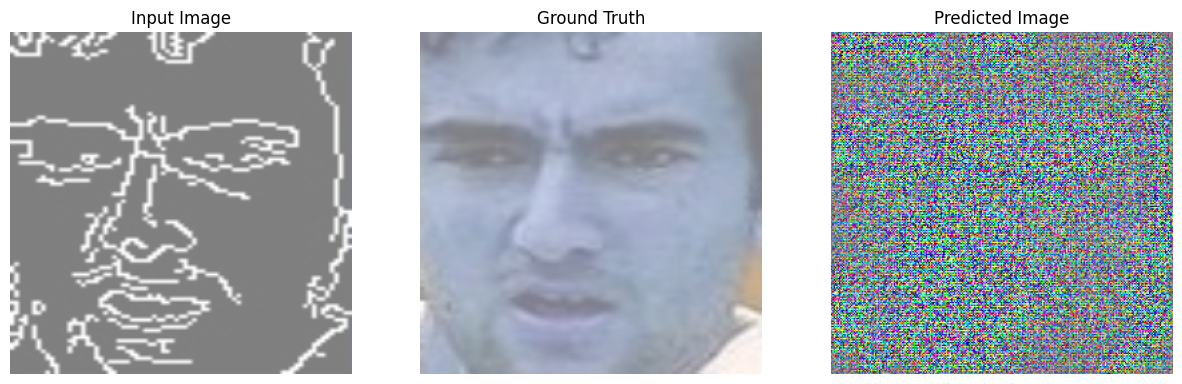

In [219]:
generate_images(gen,batch['B'].cuda(),batch['A'].cuda())

# Training

In [ ]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, s in enumerate(tqdm(dataloader)):
        x=s['B']
        x=x.cuda()
        y=s['A']
        y=y.cuda()
        y_fake=gen(x)
        D_real=disc(x,y)
        D_real_loss=BCE_Loss(D_real,torch.ones_like(D_real))
        D_fake=disc(x,y_fake.detach())
        D_fake_loss=BCE_Loss(D_fake,torch.zeros_like(D_fake))
        D_loss=(D_real_loss+D_fake_loss)/2
        disc.zero_grad()
        D_loss.backward()
        disc_opt.step()
        
        D_fake = disc(x, y_fake)
        G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
        L1 = L1_Loss(y_fake,y) * LAMBDA
        G_loss = G_fake_loss + L1
        
        gen_opt.zero_grad()
        G_loss.backward()
        gen_opt.step()
        if batch_idx % 150 == 0 and batch_idx > 0:
            print(f"Step {batch_idx}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
            generate_images(gen,s['B'].cuda(),s['A'].cuda())
        
        

In [239]:
torch.save(gen.state_dict(), '/kaggle/working/gen.pth')
torch.save(disc.state_dict(), '/kaggle/working/disc.pth')

In [ ]:
for i in range(5):
    for s in dataloader:
        generate_images(gen,s['B'].cuda(),s['A'].cuda())
        break
        